<a href="https://colab.research.google.com/github/VishnuRam2411/Inductions-22/blob/main/db.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
data_root='/content/drive/My Drive/Databyte/databyte'

In [5]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
  TRAINING_DATA_DIR,
  subset="validation",
  shuffle=True,
  target_size=IMAGE_SHAPE)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
   TRAINING_DATA_DIR,
   subset="training",
   shuffle=True,
   target_size=IMAGE_SHAPE)

/content/drive/My Drive/Databyte/databyte
Found 185 images belonging to 5 classes.
Found 753 images belonging to 5 classes.


In [6]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)
['Black_Widow_Images' 'Captainamerica' 'Hulk' 'Ironman' 'Thor']


In [7]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.6823 - acc: 0.3413 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/24 [==============================] - 423s 17s/step - loss: 1.6823 - acc: 0.3413 - val_loss: 0.9265 - val_acc: 0.6865
Epoch 2/10
24/24 [==============================] - 14s 579ms/step - loss: 1.0770 - acc: 0.5857 - val_loss: 0.6551 - val_acc: 0.7838
Epoch 3/10
24/24 [==============================] - 14s 575ms/step - loss: 0.8505 - acc: 0.6799 - val_loss: 0.5590 - val_acc: 0.8108
Epoch 4/10
24/24 [==============================] - 15s 626ms/step - loss: 0.6977 - acc: 0.7583 - val_loss: 0.5062 - val_acc: 0.8486
Epoch 5/10
24/24 [==============================] - 14s 581ms/step - loss: 0.5889 - acc: 0.8008 - val_loss: 0.4653 - val_acc: 0.8324
Epoch 6/10
24/24 [==============================] - 14s 581ms/step - loss: 0.5599 - acc: 0.8035 - val_loss: 0.4725 - val_acc: 0.8649
Epoch 7/10
24/24 [==============================] - 13s 575ms/step - loss: 0.5175 - acc: 0.8141 - val_loss: 0.4237 - val_acc: 0.8649
Epoch 8/10
24/24 [==============================] - 15s 607ms/step - loss: 0.4898

In [9]:
avenger = "saved_models/avengers"
model.save(avenger)
model = tf.keras.models.load_model(avenger)


In [10]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [11]:
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 0s 448ms/step
Prediction results for the first elements


,Black_Widow_Images,Captainamerica,Hulk,Ironman,Thor
0,0.996632,0.000239,0.001664,0.000787,0.000678
1,0.000048,0.999066,0.000174,0.000602,0.000111
2,0.001004,0.985088,0.000181,0.009825,0.003901
3,0.007320,0.000297,0.965798,0.022870,0.003715
4,0.940133,0.029994,0.010422,0.008350,0.011101


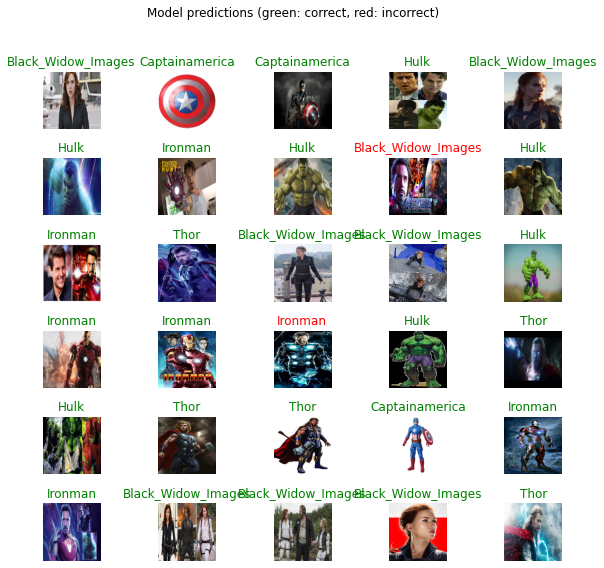

In [20]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
   plt.subplot(6,5,n+1)
   plt.imshow(val_image_batch[n])
   color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
   plt.title(predicted_labels[n].title(), color=color)
   plt.axis('off')
_    = plt.suptitle("Model predictions (green: correct, red: incorrect)")